In [ ]:
# 房价预测模型
# 卧室个数，卫生间个数，居住面积分别记为 x1,x2,x3
# 成交价为：y = w1*x1+w2*x2+w3*x3 + b
#          y = (w,x) + b     向量形式  b是标量
# 即价格为 三个因素的加权和

# 线性模型可以看作是单层神经网络

# 衡量预测质量，损失：(真实值t - 预测值y)^2  / 2  平方损失 

# 学习率，就是损失函数结果下降的每次的步长，我们希望结果最小。这个也是超参数，即需要人为指定的参数






# 重要注意:

当你调用 backward() 时，PyTorch 会计算这两个样本在前向传播时生成的计算图，并计算每个权重对两个样本的总梯度。

当你在 PyTorch 中对两个样本 
𝑥1和 𝑥2 依次进行正向传播，然后再调用一次反向传播，权重的 grad 会是对这两个样本的梯度之和。这是因为 PyTorch 默认会在反向传播时累积梯度

也就是说,每次正向的计算,都会保存一张计算图,反向时对所有计算图计算

In [2]:
import torch
from d2l import torch as d2l
import random
%matplotlib inline

torch.manual_seed(888)
# 根据带有噪声的线性模型构造一个人造数据集，W = [2,-3.4]^T  b = 4.2
def synthetic_data(w,b,num_examples):
    """生成 y= Xw +b+噪声"""
    # 生成符合正态分布（高斯分布）随机数的函数
    # 均值0，标准差1
    # 最后一个入参是大小，num_examples * len(w) 的大小
    # 返回一个张量X
    X = torch.normal(0,1,(num_examples,len(w)))
    # 生成制造出来的数据的答案值
    y = torch.matmul(X,w) + b # 既可以矩阵*矩阵，也可以矩阵*向量，也可以向量和向量的点积
    # 构造噪音，答案不能完全一直，不然是纯直的一条线
    noise = torch.normal(0,0.01,y.shape)
    y += noise
    return X,y.reshape((-1,1)) # 转为列向量，-1表示自动调整

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
    

In [2]:
print('features',features[0],'\nlabel:',labels[0])

features tensor([-0.0767, -1.1224]) 
label: tensor([7.8683])


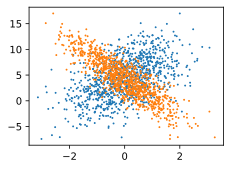

In [3]:
d2l.set_figsize() 
# 第一个分量对应的真实值
d2l.plt.scatter(features[:,(0)].detach().numpy(),labels.detach().numpy(),1)
# 第二个分量对应的真实值
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

In [ ]:
# python 中一个张量可以作为访问另一个张量的下标数组
testa = torch.tensor([1,2,3,4,5,6])
indicesa = torch.tensor([0,2,4])
testa[indicesa]

tensor([1, 3, 5])

In [7]:
# 接受批量大小的特征值和标签值，生成大小为batch_size的小批量

def data_iter(batch_size,features,labels):
    # features，labels都是张量，batch_size是标量
    num_examples = len(features)
    # 得到序号词典
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices) # 打乱词典
    for i in range(0,num_examples,batch_size):
        # batch_size为i取的步长，i为0，batch_size,2*batch_size....
        # 每次取出 i到i+batch_size个序号，当然不能越界，所以需要使用min函数对比i+batch_size和上限num_examplse
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        # 将对应序号的样本和标签返回
        yield features[batch_indices],labels[batch_indices]
        # 使用了 yield以后，函数不会一次执行，只有遍历函数结果才会计算

batch_size = 10

# 遍历函数结果，每次获取一批次的样本
for X,y in data_iter(batch_size,features,labels):
    # 打印这批次的数据
    print(X,'\n',y)
    break # 只打印一批



tensor([[-1.7546e-01, -1.7718e+00],
        [-1.9901e+00, -1.5996e-04],
        [-9.1615e-01,  1.7381e+00],
        [ 4.9351e-01,  9.6365e-02],
        [-1.0881e+00, -1.0975e+00],
        [-7.3082e-01,  2.9785e-01],
        [ 2.0749e+00,  3.0746e+00],
        [-4.4466e-01,  1.9547e+00],
        [-2.2518e-01, -7.5777e-01],
        [-7.9297e-01,  2.3694e-02]]) 
 tensor([[ 9.8712],
        [ 0.2340],
        [-3.5274],
        [ 4.8635],
        [ 5.7446],
        [ 1.7476],
        [-2.1004],
        [-3.3311],
        [ 6.3276],
        [ 2.5309]])


In [32]:
# 定义模型
# 线性模型,主要是权重w和偏置量b,这里只有两个feature,w只有两个分量,shape可以设为2*1,初始随机值
w = torch.normal(0,0.01,size=(2,1),requires_grad=True) # 设置随机向量,要求保留梯度
b = torch.zeros(1,requires_grad=True)

# y = x*w +b x为10*2的矩阵,w为2*1的向量,结果为10*1的结果向量
def linreg(X,w,b):
    return torch.matmul(X,w)+b # 得出这一批样本的预测值

In [33]:
# 定义损失函数
def squared_loss(y_hat,y):
    # y_hat是真实值,y是预测值,均方损失
    return ((y_hat-y.reshape(y_hat.shape))**2)/2   # 统一形式,防止有一个是行向量,一个是列的

In [37]:
# 定义优化算法
# @params 是一个list,里面有所有参数,w,b
# @lr 学习率
# @batch_size 批量大小
# 批量数据的情况下,grad是所有样本的梯度总和,这是因为梯度除非手动清空
# 否则会自动累积,这是Pytorch的规则,因此10个样本就累积了10次的梯度,每次更新最好得到梯度的平均值
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad(): # 告知下面的计算不计算梯度,因为更新w和b的时候不用算梯度
        for param in params:  
            param -= lr * param.grad/batch_size # 原地操作    
            param.grad.zero_() # 权重已经更新完毕,清空梯度,防止累积到之前的值    

In [91]:
# 通过全体样本和最优解公式得出最优w,b
# 线性回归模型是可以直接得出w和b的最优解的
# [w b]^T = (X^T*X)^-1  * X^T*y  X增加一列全为1的可以是的w向量包含b,推导看ipad

def calc_true_w_b(features,labels):
    append_col = torch.ones(features.size(0)).reshape(-1,1) # 维度必须一样
    newX = torch.cat((features,append_col),dim=1)
    step1 = torch.matmul(newX.T,newX)
    step2 = torch.matmul(newX.T,labels)
    step3 = torch.inverse(step1) # inverse是求矩阵的逆
    res = torch.matmul(step3,step2)
    true_w = res[0:len(res)-1]
    true_b = res[-1]
    return true_w,true_b

true_w,true_b = calc_true_w_b(features,labels)
true_w,true_b
# 需要注意的是,得到的最优解是当前损失函数能得到最小值的情况的解,损失函数不一定值就为0
# 也就是说带入真实w,b,去做预测,还是会和真实值有偏差

(tensor([[ 2.0002],
         [-3.3999]]),
 tensor([4.1998]))

In [90]:
# 开始训练

lr = 0.03
num_epochs = 3 # 数据扫描三遍
net = linreg   # 选择模型
loss = squared_loss #选择损失函数

for epoc in range(num_epochs):
    # 获取每一批次训练数据
    for X,y in data_iter(batch_size,features,labels):
        # 计算损失,并且反向计算一次梯度,得到所有参与计算的对于结果的导数
        l=loss(y,net(X,w,b)) # 不可以在这里反向,因为一般对标量反向,且pytorch也只能对标量反向
        l.sum().backward()
        # 更新权重
        sgd([w,b],lr,batch_size)
    # 更新完毕的权重,再去计算一次损失,看是否变小,这一块不需要积累梯度
    with torch.no_grad(): # 计算
        train_result = loss(y,net(X,w,b))
        # f"{value:f}" :f 格式化为浮点数,不然是科学计数法了
        print(f'epoc {epoc+1}, loss {float(train_result.mean()):f}')

# 打印更新后的w,b与真实的w,b的差值
print(f'w的估计误差{w-true_w.reshape(w.shape)}')
print(f'b的估计误差{b-true_b}')

epoc 1, loss 0.000036
epoc 2, loss 0.000036
epoc 3, loss 0.000085
w的估计误差tensor([[-0.0004],
        [-0.0003]], grad_fn=<SubBackward0>)
b的估计误差tensor([-0.0004], grad_fn=<SubBackward0>)


# 使用框架来简洁的实现

In [93]:
import numpy as np
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
# 生成训练数据
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [103]:
# 使用框架读取数据
# 自动打乱和抽取批次函数
def load_array(data_arrays,batch_size,is_train=True):
    """构造pytorch数据迭代器"""
    # 使用 TensorDataset 将特征和标签打包成一个数据集
    # dataset = TensorDataset(X, y)
    #TensorDataset 通常与 DataLoader 一起使用，后者可以进行批次化处理、打乱数据和并行加载数据
    dataset = data.TensorDataset(*data_arrays) # *是解包元组
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter = load_array((features,labels),batch_size)
# iter() 函数将 data_iter 转换为一个迭代器（如果它已经是迭代器，则直接返回）
# DataLoader 是可迭代对象，可以直接用于 for 循环，但它不是迭代器
next(iter(data_iter)) #next() 函数会返回迭代器的下一个元素

[tensor([[ 0.1049,  0.8610],
         [ 0.8183,  0.0708],
         [-1.1270,  1.7312],
         [ 2.3066, -0.6897],
         [ 0.7289, -0.4609],
         [-1.5361, -0.1715],
         [-0.4434,  0.4189],
         [ 0.3856,  0.8696],
         [ 0.0802,  0.2227],
         [ 0.8951, -0.6102]]),
 tensor([[ 1.4881],
         [ 5.6122],
         [-3.9487],
         [11.1502],
         [ 7.2153],
         [ 1.7181],
         [ 1.8655],
         [ 2.0134],
         [ 3.6011],
         [ 8.0702]])]

In [104]:
# 使用预定义的网络
from torch import nn
# 定义一个简单的包含一层的神经网络，输入维度为 2，输出维度为 1
net = nn.Sequential(nn.Linear(2,1))  # 第一层的模型输出维度是1
# 修改网络的第一层（即 Linear 层）的权重和偏置
# 初始化模型的w和b参数,w是二维的,和输入维度一样,b是标量
# 这里设置初始值只是为了和前面的从零实现匹配，实际不用设置，自带一个默认值
net[0].weight.data.normal_(0,0.01)  # 带下划线的都是原地操作
net[0].bias.data.fill_(0)

tensor([0.])

In [105]:
loss = nn.MSELoss() # 均方误差损失函数

In [107]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [111]:
# res = [param for param in net.parameters()]
# res
#parameters() 函数会遍历模型中的每一层，并返回所有包含 requires_grad=True 的参数（通常是层的权重和偏置）。这些参数以迭代器的形式返回，你可以通过遍历它们或者使用 list() 来查看具体内容
list(net.parameters())

[Parameter containing:
 tensor([[-0.0155,  0.0059]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [119]:
# iter 迭代器用法
iter_instance = iter(data_iter)
next(iter_instance)
next(iter_instance)
# 这样才能遍历

[tensor([[-1.2228,  0.3045],
         [-1.0309,  0.7289],
         [ 1.2717,  1.0832],
         [-1.0527, -0.8364],
         [ 0.3121,  0.8807],
         [ 0.2412, -0.3099],
         [ 0.7976, -0.6721],
         [-1.2534,  0.4065],
         [-0.6015,  0.7957],
         [ 1.8210,  0.5266]]),
 tensor([[ 0.7304],
         [-0.3428],
         [ 3.0627],
         [ 4.9489],
         [ 1.8388],
         [ 5.7406],
         [ 8.0853],
         [ 0.3104],
         [ 0.2967],
         [ 6.0658]])]

In [117]:
# 开启训练
num_epochs = 3
for epoc in range(num_epochs):
    
    # X,y = next(iter(data_iter)) 最好不要用这种方式,多次调用 next(iter(data_iter))，每次都会重新生成一个新的迭代器并从头开始遍历。
    # 会导致多次调用的数据可能存在重复
    for X,y in data_iter:
        l = loss(y,net(X))
        # 每次反向前清空梯度,trainer是个SGD对象(随机梯度下降),
        # SGD对象就两个方法,step更新参数和zero清空梯度,step更新其实也就是获取所有参数的梯度然后均值更新以下
        # 前向两次就有两个计算图,参数就为两次的梯度和,step只不过执行了w-=lr*w.grad/计算图个数
        # 所以,虽然名字叫随机梯度下降算法,实际随机是由正向给的数据随机
        trainer.zero_grad()
        l.backward()
        trainer.step()
        # 打印训练完的效果
        l = loss(net(features),labels)
    print(f'epoc {epoc} ,loss {l:f}')


epoc 0 ,loss 0.000095
epoc 1 ,loss 0.000094
epoc 2 ,loss 0.000094
